# Random Forest Regression
Steps: <br>
- Random Forest Regression using all features
- Feature importance
- Random Forest Regression using only important features 
- Hyperparameter Tuning
- Log Transformation of target
- Sqrt Transformation of target


## Setup and import

In [244]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_regression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
RSEED = 42

In [245]:
# import dataset
df = pd.read_csv("../Train.csv")

In [246]:
# drop non numeric features
df = df.drop(['ward','ADM4_PCODE'], axis=1)

## Random Forest Regression using all features except the non numeric ones, 'ward' and 'ADM4_PCODE'

In [247]:
# add new feature `ward_type` to dataset
df_geo = pd.read_csv('../data/geo_df.csv')
ward_type = df_geo.ward_type
df = df.join(ward_type)

In [248]:
# define X and y values
X = df.drop(['target'], axis=1)
y = df["target"]

# add dummy for categorical feature ward_type
X = pd.get_dummies(X)
X.head()


,total_households,total_individuals,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,...,pw_04,pw_05,pw_06,pw_07,pw_08,lat,lon,NL,ward_type_rural,ward_type_urban
0,1674.45058,5888.20750,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,0.005750,0.031466,...,0.007537,0.000000,0.012928,0,0,-29.682270,24.734743,0.292039,1,0
1,1736.99230,6735.33812,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,0.007575,0.123547,...,0.057127,0.019092,0.004131,0,0,-29.119311,24.757737,3.207775,0,1
2,2403.57591,7273.04995,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,0.006686,0.022632,...,0.010358,0.001421,0.040881,0,0,-29.142276,25.094093,0.000000,1,0
3,1740.78737,5734.49046,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,0.005255,0.068909,...,0.000669,0.000000,0.005011,0,0,-29.372052,24.942867,2.038778,1,0
4,1730.51451,6657.23835,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,0.004985,0.009150,...,0.001290,0.000673,0.017629,0,0,-29.409381,25.290165,0.000000,1,0


In [249]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED)

In [250]:
# Fit model to training data
regr = RandomForestRegressor(max_depth=3, random_state=0)
regr.fit(X_train, y_train)

# Make predictions on test set
y_pred = regr.predict(X_test)

The Regression with all numerical features has a much better RMSE than the baseline model. But this model is using many colinear features. The next step is calculating feature importance and then a random forest regression with the most important non collinear features only.

In [251]:
# evaluation metrics
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"R2: {r2_score(y_test, y_pred)}")

RMSE: 4.405248423218552
R2: 0.8060224463707113


/Users/christinemerkel/neuefische/first_eda/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


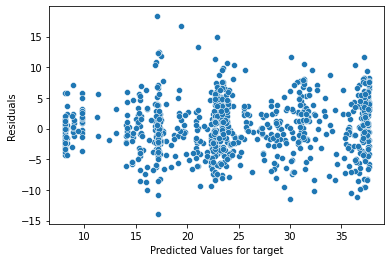

In [252]:
# plot residuals
residuals = y_test - y_pred
fig,ax=plt.subplots()
sns.scatterplot(y_pred, residuals, ax=ax)
ax.set_xlabel('Predicted Values for target')
ax.set_ylabel('Residuals')
ax.plot();

The residuals are not evenly distributed, they have some clusters. 

## Feature importance
For the next model instead of all all features, we use only the most important features provided by `feature_importances_`: psa_00, car_01, pw_00, lln_01 , pg_00

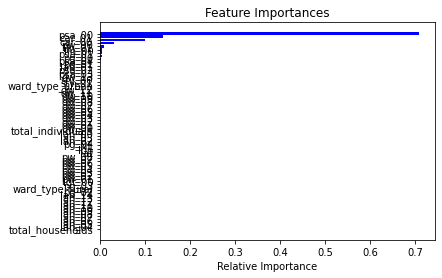

In [253]:
features = X.columns
importances = regr.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [254]:
fi = pd.DataFrame({'feature': features,
                   'importance': importances}).\
                    sort_values('importance', ascending = False)
fi.head(10)


,feature,importance
16,psa_00,0.708621
24,car_01,0.138757
23,car_00,0.100028
48,pw_00,0.029819
26,lln_01,0.009171
25,lln_00,0.004890
17,psa_01,0.003893
42,pg_00,0.003339
20,psa_04,0.000905
43,pg_01,0.000475


# Random Forest Regression using best features only
No difference to using all features, still an improvement to the baseline model. The next step is hyperparameter tuning, and then create a model with the best parameters.

In [255]:
# Features : psa_00, car_01, pw_00, lln_01 
best_features = ['psa_00', 'car_01', 'pw_00', 'lln_01', 'pg_00']

# define X and y values
X = df[best_features]
y = df["target"]

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED)

In [256]:
# Create an instance of DecisionTreeRegressor() and fit it to the training data.
regr_best = RandomForestRegressor(max_depth=3, random_state=0)
regr_best.fit(X_train, y_train)

# make predictions on test data
y_pred = regr_best.predict(X_test)


In [282]:
# paramteres of the regression
regr_best.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [257]:
#evaluation metrics
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"R2: {r2_score(y_test, y_pred)}")

RMSE: 4.412575043283805
R2: 0.8053766795311337


# Hyperparamater Tuning

In [258]:
# Features : psa_00, car_01, pw_00, lln_01 
best_features = ['psa_00', 'car_01', 'pw_00', 'lln_01', 'pg_00']

#define X and y values
X = df[best_features]
y = df["target"]

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED)

In [259]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [260]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/christinemerkel/neuefische/first_eda/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/christinemerkel/neuefische/first_eda/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/christinemerkel/neuefische/first_eda/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/christinemerkel/neuefische/first_eda/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   3.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   3.1s
[CV] END bootstrap=True, max_depth=10, ma

In [261]:
# best paramters from hyperparamter tuning
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [262]:
# instantiate and fit the RandomForestRegressor with the best parameters
rf_hp = RandomForestRegressor(**rf_random.best_params_)

rf_hp.fit(X_train, y_train)



RandomForestRegressor(max_depth=100, min_samples_leaf=4, min_samples_split=5,
                      n_estimators=1000)

In [263]:
# make predictions on test data
y_pred = rf_hp.predict(X_test)


In [264]:
#evaluation metrics
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"R2: {r2_score(y_test, y_pred)}")

RMSE: 3.907650872479885
R2: 0.8473692005881056


/Users/christinemerkel/neuefische/first_eda/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='target'>

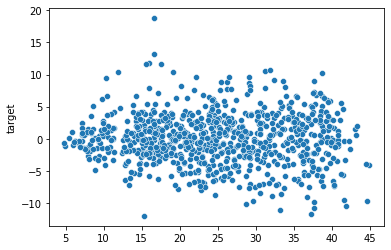

In [265]:
residuals = y_test - y_pred
sns.scatterplot(y_pred, residuals)

With hyperparamter tuning we could improve the model even more, and the residuals look good, too.

## Log Transformation of target variable

In [266]:
# target has one 0 value. for the log transform that row has to be removed from the data
df.query('target==0').count().target
df_zero = df.drop(df[df['target'] == 0].index)

In [267]:
# define X and y values
X = df_zero[best_features]  
y = np.log(df_zero["target"])

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED)

In [268]:
# Fit the random search model
rf_random.fit(X_train, y_train);



Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   3.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000

In [269]:
# instantiate and fit the RandomForestRegressor with the best parameters
rf_hp = RandomForestRegressor(**rf_random.best_params_)
rf_hp.fit(X_train, y_train)

# make predictions on test data
y_pred = np.exp(rf_hp.predict(X_test))
y_test = np.exp(y_test)

In [270]:
#evaluation metrics
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"R2: {r2_score(y_test, y_pred)}")

RMSE: 3.8611585028492206
R2: 0.856742812906033


/Users/christinemerkel/neuefische/first_eda/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


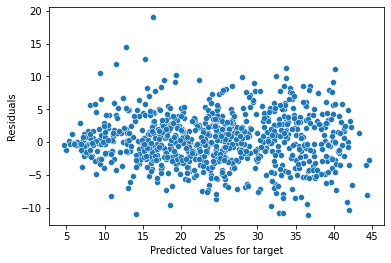

In [271]:
# plot residuals
residuals = y_test - y_pred
fig,ax=plt.subplots()
sns.scatterplot(y_pred, residuals, ax=ax)
ax.set_xlabel('Predicted Values for target')
ax.set_ylabel('Residuals')
ax.plot();

The log transformation of the target improved the RMSE from 0.847 to 0.856.

Text(0.5, 1.0, 'Log transformation of the target')

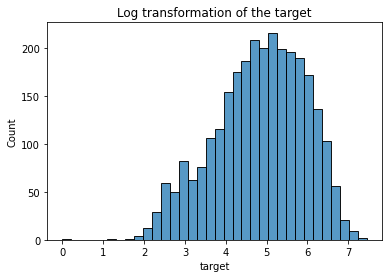

In [279]:
sns.histplot(y)
plt.title('Log transformation of the target')

Text(0.5, 1.0, 'target without log transformation')

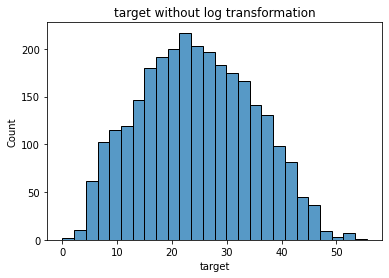

In [280]:
sns.histplot(df["target"])
plt.title('target without log transformation')

## Sqrt transform of target variable

The sqrt transformation of the target does not improve the regression.

In [272]:
# Features : psa_00, car_01, pw_00, lln_01 
best_features = ['psa_00', 'car_01', 'pw_00', 'lln_01', 'pg_00']

#define X and y values
X = df[best_features]
y = np.sqrt(df["target"])

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED)

In [274]:
# Fit the random search model
rf_random.fit(X_train, y_train);


Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/christinemerkel/neuefische/first_eda/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/christinemerkel/neuefische/first_eda/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/christinemerkel/neuefische/first_eda/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/christinemerkel/neuefische/first_eda/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   3.6s
[CV] END bootstrap=True, max_depth=10, ma

<AxesSubplot:xlabel='target', ylabel='Count'>

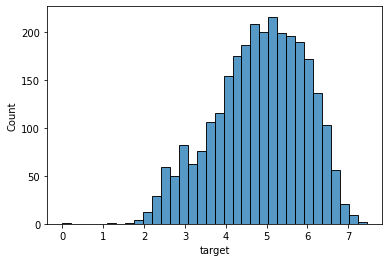

In [278]:
sns.histplot(y)

In [275]:
# instantiate and fit the RandomForestRegressor with the best parameters
rf_hp = RandomForestRegressor(**rf_random.best_params_)
rf_hp.fit(X_train, y_train)

# make predictions on test data
y_pred = np.square(rf_hp.predict(X_test))
y_test = np.square(y_test)

In [276]:
#evaluation metrics
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"R2: {r2_score(y_test, y_pred)}")

RMSE: 3.9203281428782253
R2: 0.8463772590534199


/Users/christinemerkel/neuefische/first_eda/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


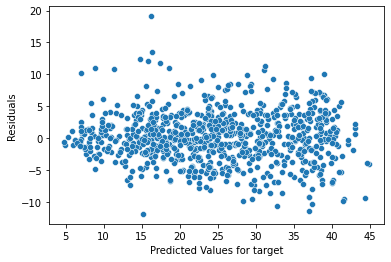

In [277]:
# plot residuals
residuals = y_test - y_pred
fig,ax=plt.subplots()
sns.scatterplot(y_pred, residuals, ax=ax)
ax.set_xlabel('Predicted Values for target')
ax.set_ylabel('Residuals')
ax.plot();